<h1>MODEL TRAINER</h1>

In [1]:
#LOAD DEPENDENCIES
import os
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import applications
from keras.optimizers import Adam
from keras.models import load_model
from keras.models import Model, Input
from sklearn.utils import class_weight
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras import Model, layers

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [2]:
#LOAD THE DATA
train_data_dir = "dataset_both/train/"
validation_data_dir = "dataset_both/validation/"
img_rows, img_cols = 224, 224
input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)
print("Data folders found!")
print("The Input size is set to ", model_input) 

Data folders found!
The Input size is set to  Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)


In [3]:
#DATA GENERATORS

batch_size = 16

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
         
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        classes=['0_Normal_XRAY', 
                 '1_Covid19_XRAY', 
                 '2_Pneumonia_XRAY', 
                 '3_Normal_CT', 
                 '4_Covid19_CT', 
                 '5_Pneumonia_CT'])

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=['0_Normal_XRAY', 
                 '1_Covid19_XRAY', 
                 '2_Pneumonia_XRAY', 
                 '3_Normal_CT', 
                 '4_Covid19_CT', 
                 '5_Pneumonia_CT'])

#CHECK  THE NUMBER OF SAMPLES
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

if nb_train_samples == 0:
    print("NO DATA TRAIN FOUND! Please check your train data path and folders!")
else:
    print("Train samples found!")
    
if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

num_classes= len(train_generator.class_indices)

print('Model set to train', num_classes, 'classes')

if nb_train_samples and nb_validation_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")

Found 21052 images belonging to 6 classes.
Found 5260 images belonging to 6 classes.
Train samples found!
Validation samples found!
Model set to train 6 classes
Generators are set!
Check if dataset is complete and has no problems before proceeding.


In [4]:
#Weigh each class

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

[1.34123344 3.42308943 0.94167114 0.63620429 0.5775583  1.67478123]


In [5]:
# DenseNet121 Model

#TRANSFER LEARNING
def DenseNet121_builder(model_input):
    DenseNet121_builder = DenseNet121(weights='imagenet', 
                                    include_top=False, 
                                    input_tensor = model_input)
    
#ALLOW RE-TRAINING OF SOME LAYERS
    for layer in DenseNet121_builder.layers:
        layer.trainable = False
        
    for BatchNormalization in DenseNet121_builder.layers:
        BatchNormalization.trainable = True

#LAYER TRUNCATION
    x = DenseNet121_builder.layers[-414].output    
    x = GlobalAveragePooling2D(name='GAP-densenet121')(x)
    x = Dropout(0.5, name='Dropout-densenet121')(x)
    predictions = Dense(num_classes, activation='softmax', name='Softmax-densenet121')(x)
    model = Model(inputs=DenseNet121_builder.input, outputs=predictions, name='densenet121')
    return model

#INITIALIZE THE MODEL
DenseNet121_model = DenseNet121_builder(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
DenseNet121_model.summary()
print("Model successfully built!")

PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________

In [6]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
import time

batch_size = 16

epochs = 25

start_time = time.time()

optimizer = Adam(lr=0.0001)

DenseNet121_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.000001)

callbacks = [reduce_lr]

# MODEL TRAINING

history = DenseNet121_model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  callbacks=callbacks, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)

elapsed_time = time.time() - start_time
train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print()
print()
print(train_time, 'train_time')
print()
print(elapsed_time, 'Seconds')
print()
print()
print("MODEL SERIALIZING WAIT FOR A MOMENT...")
print()

#SAVE AFTER TRAINING COMPLETES

DenseNet121_model.save('weights/Both_truncated/Both-Truncated_DenseNet121.h5')

#SAVE THE HISTORY FOR EVALUATION

from pickle import dump
dump(history, open('history/Both_truncated/Both-Truncated_DenseNet121.pkl', 'wb'))

print()
print()
print("The Model weights and history are successfully trained and saved!")

Epoch 1/25
1315/1315 [==============================] - 102s 78ms/step - loss: 1.1920 - acc: 0.5292 - val_loss: 0.9319 - val_acc: 0.6010
Epoch 2/25
1315/1315 [==============================] - 101s 77ms/step - loss: 0.9148 - acc: 0.6376 - val_loss: 0.7938 - val_acc: 0.6354
Epoch 3/25
1315/1315 [==============================] - 100s 76ms/step - loss: 0.8015 - acc: 0.6849 - val_loss: 0.7460 - val_acc: 0.6960
Epoch 4/25
1315/1315 [==============================] - 100s 76ms/step - loss: 0.7356 - acc: 0.7105 - val_loss: 0.6845 - val_acc: 0.7319
Epoch 5/25
1315/1315 [==============================] - 100s 76ms/step - loss: 0.6993 - acc: 0.7268 - val_loss: 0.6847 - val_acc: 0.6964
Epoch 6/25
1315/1315 [==============================] - 100s 76ms/step - loss: 0.6702 - acc: 0.7356 - val_loss: 0.6886 - val_acc: 0.7494
Epoch 7/25
1315/1315 [==============================] - 100s 76ms/step - loss: 0.6566 - acc: 0.7423 - val_loss: 0.7173 - val_acc: 0.6386
Epoch 8/25
1315/1315 [===================

In [5]:
import itertools
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras import applications
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import matplotlib.patheffects as path_effects

In [6]:
densenet121_model = load_model('weights/Both_truncated/Both-Truncated_DenseNet121.h5')
print("The DenseNet121 Truncated Model is Loaded")

The DenseNet121 Truncated Model is Loaded


In [7]:
#DenseNet121 Model Results

#evaluate accuracy
densenet121_model_y_pred = densenet121_model.predict_generator(validation_generator,
                                                           nb_validation_samples/batch_size, workers=1)

densenet121_model_accuracy = accuracy_score(Y_test, densenet121_model_y_pred.argmax(axis=-1))
print('The accuracy of the DenseNet121 model is: ', densenet121_model_accuracy)

#evaluate mean squared error
densenet121_model_mse = mean_squared_error(Y_test, densenet121_model_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the DenseNet121 model is: ', densenet121_model_mse)

#evaluate mean squared log error
densenet121_model_msle = mean_squared_log_error(Y_test, densenet121_model_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the DenseNet121 model is: ', densenet121_model_msle)

The accuracy of the DenseNet121 model is:  0.7798479087452471
The Mean Squared Error of the DenseNet121 model is:  0.36406844106463876
The Mean Squared Log Error of the DenseNet121 model is:  0.052607596304244324


              precision    recall  f1-score   support

           0     0.8413    0.8838    0.8620       654
           1     0.9418    0.6953    0.8000       256
           2     0.8674    0.8926    0.8798       931
           3     0.8370    0.6930    0.7582      1378
           4     0.6833    0.8116    0.7419      1518
           5     0.6805    0.6272    0.6527       523

    accuracy                         0.7798      5260
   macro avg     0.8086    0.7672    0.7825      5260
weighted avg     0.7881    0.7798    0.7795      5260

Normalized confusion matrix
[[0.8838 0.0061 0.107  0.     0.0031 0.    ]
 [0.0547 0.6953 0.2227 0.0039 0.0234 0.    ]
 [0.102  0.0054 0.8926 0.     0.     0.    ]
 [0.     0.     0.     0.693  0.2678 0.0392]
 [0.     0.0013 0.     0.1212 0.8116 0.0659]
 [0.     0.     0.     0.0019 0.3709 0.6272]]


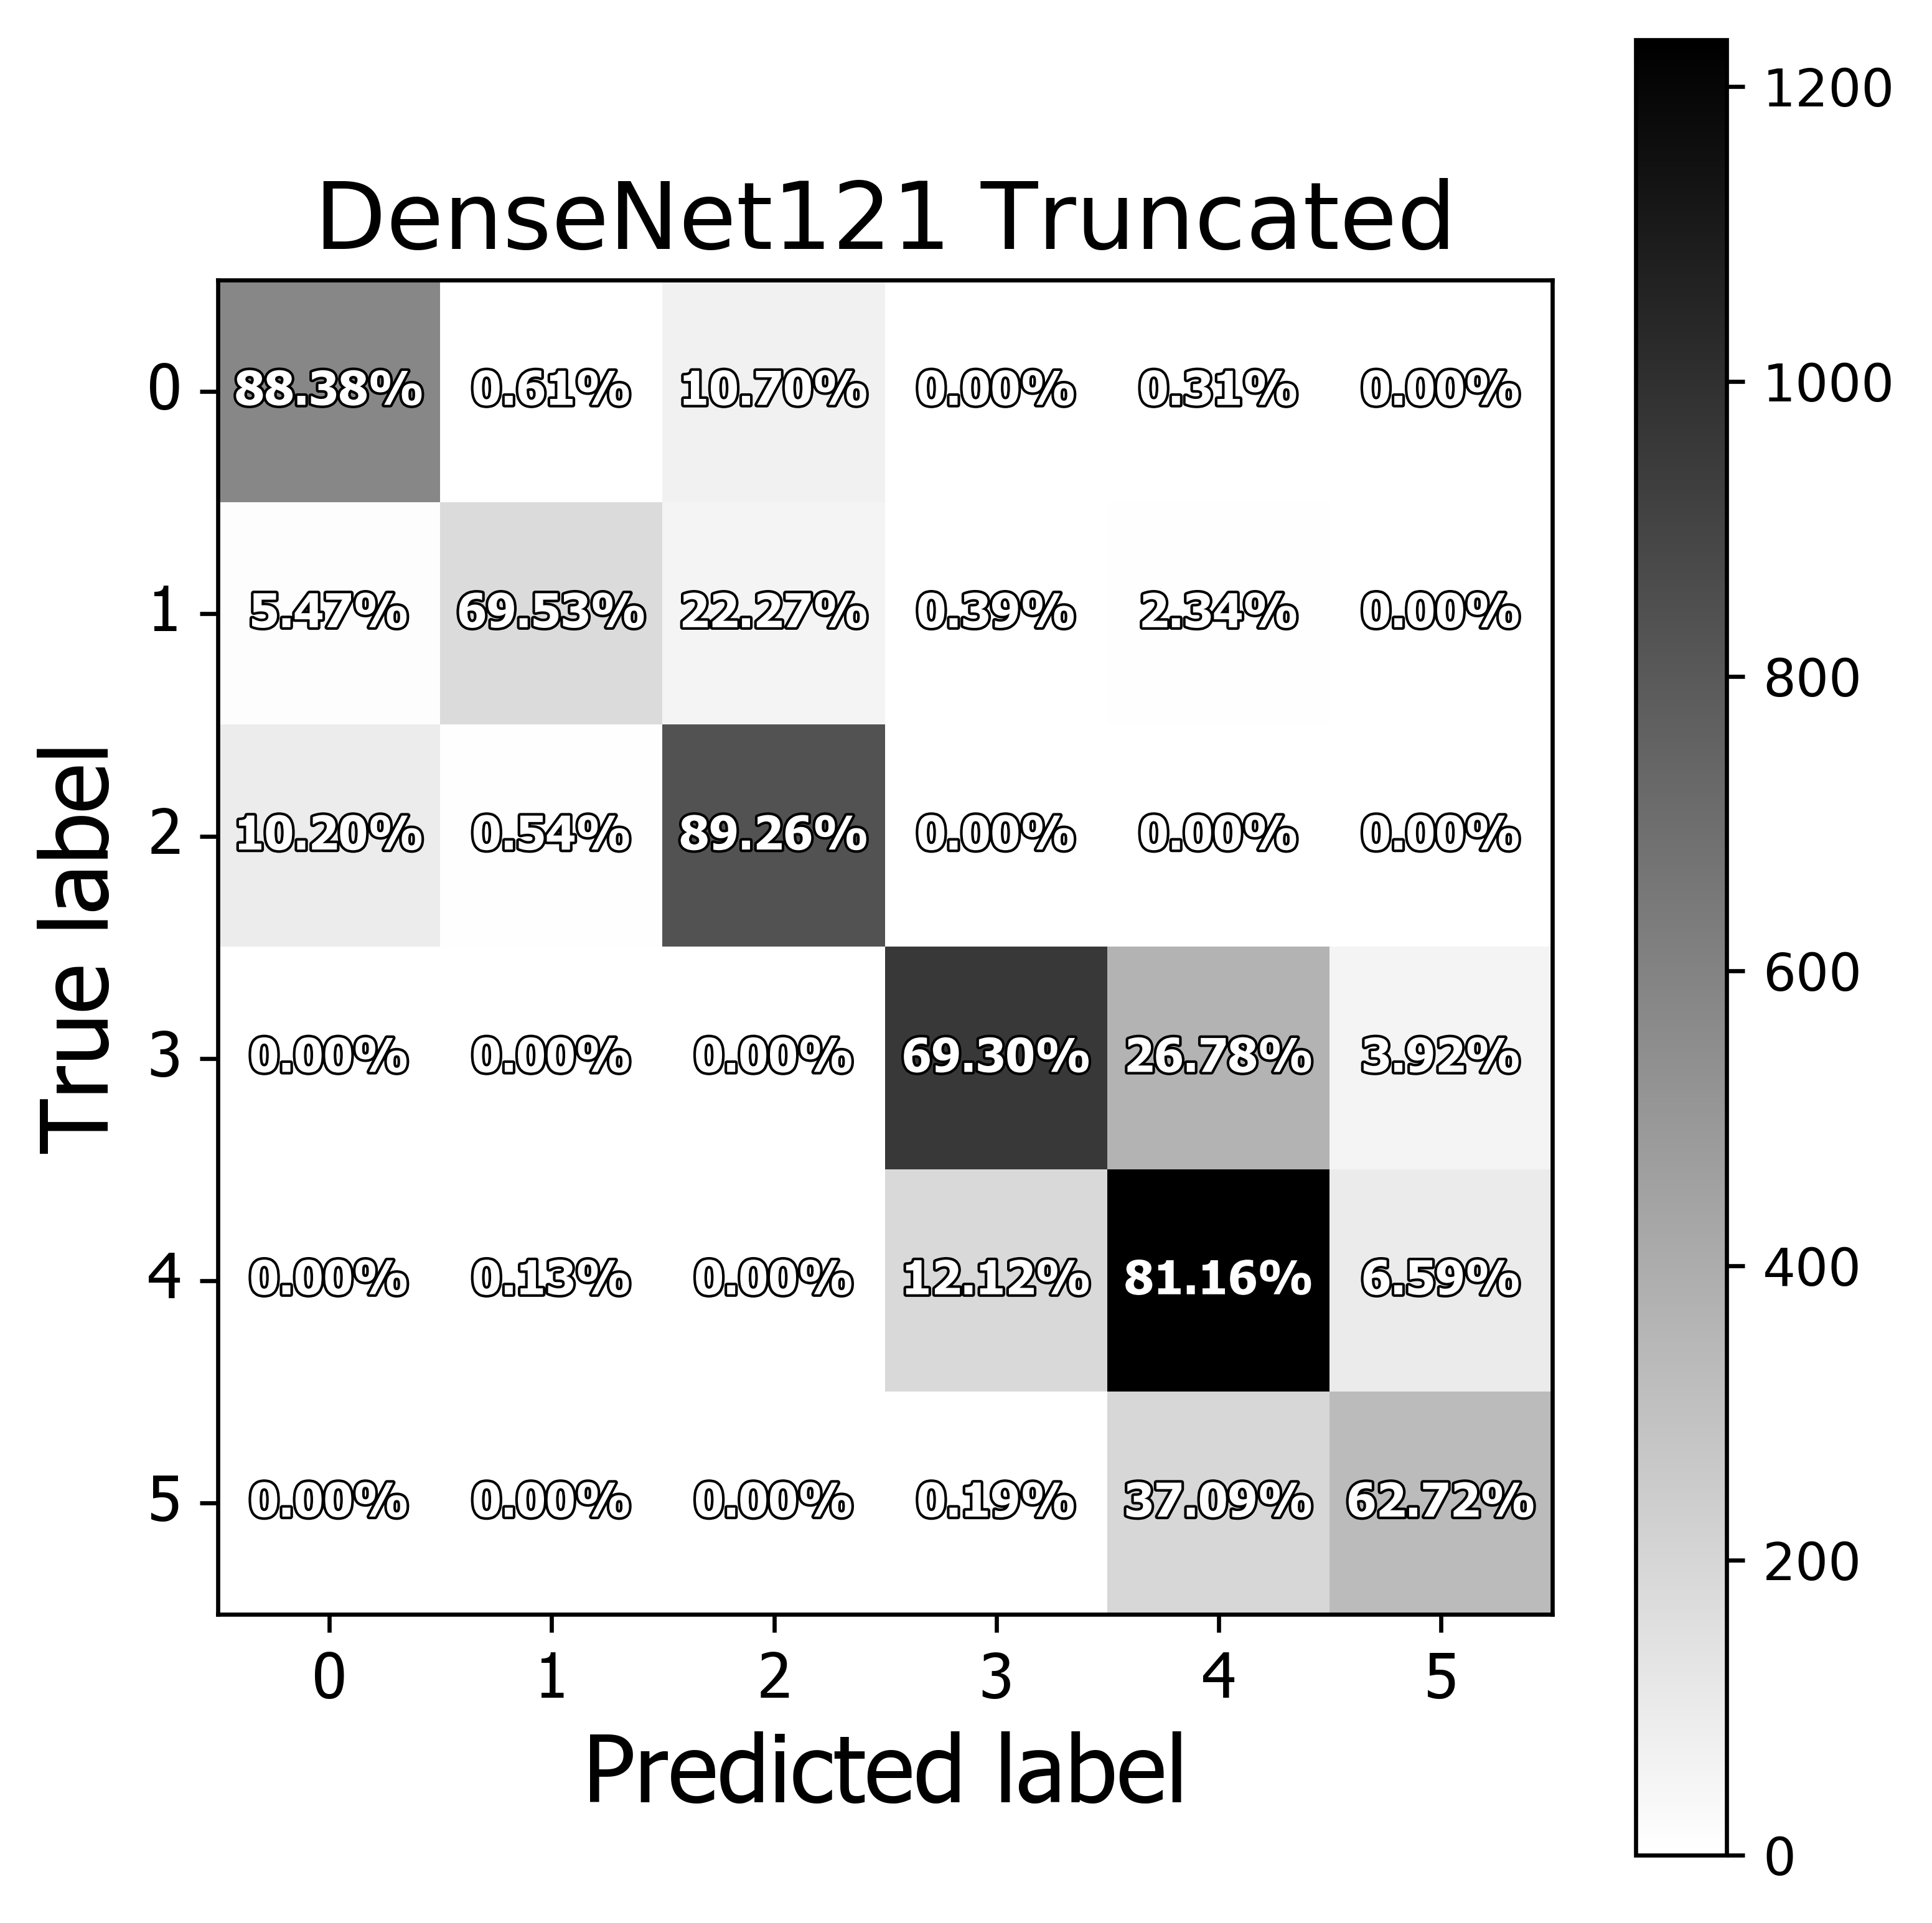

In [9]:
# DenseNet121 Confusion Matrix (Normalized)

fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title='DenseNet121 Truncated',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")
#     plt.rcParams.update({'font.size': 70})

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, '{:.2f}%'.format(cm[i, j]*100),
                 fontfamily = 'Tahoma', 
                 fontsize=9, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['0', '1', '2', '3', '4', '5']
print(classification_report(Y_test,densenet121_model_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test,densenet121_model_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25, 5.25), dpi=600)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

# plt.savefig("figures/Both_truncated/DenseNet121/confusion_matrix_normalized-densenet121.jpg", bbox="tight", dpi=300)
plt.show()

              precision    recall  f1-score   support

           0     0.8413    0.8838    0.8620       654
           1     0.9418    0.6953    0.8000       256
           2     0.8674    0.8926    0.8798       931
           3     0.8370    0.6930    0.7582      1378
           4     0.6833    0.8116    0.7419      1518
           5     0.6805    0.6272    0.6527       523

    accuracy                         0.7798      5260
   macro avg     0.8086    0.7672    0.7825      5260
weighted avg     0.7881    0.7798    0.7795      5260

Confusion matrix, without normalization
[[ 578    4   70    0    2    0]
 [  14  178   57    1    6    0]
 [  95    5  831    0    0    0]
 [   0    0    0  955  369   54]
 [   0    2    0  184 1232  100]
 [   0    0    0    1  194  328]]


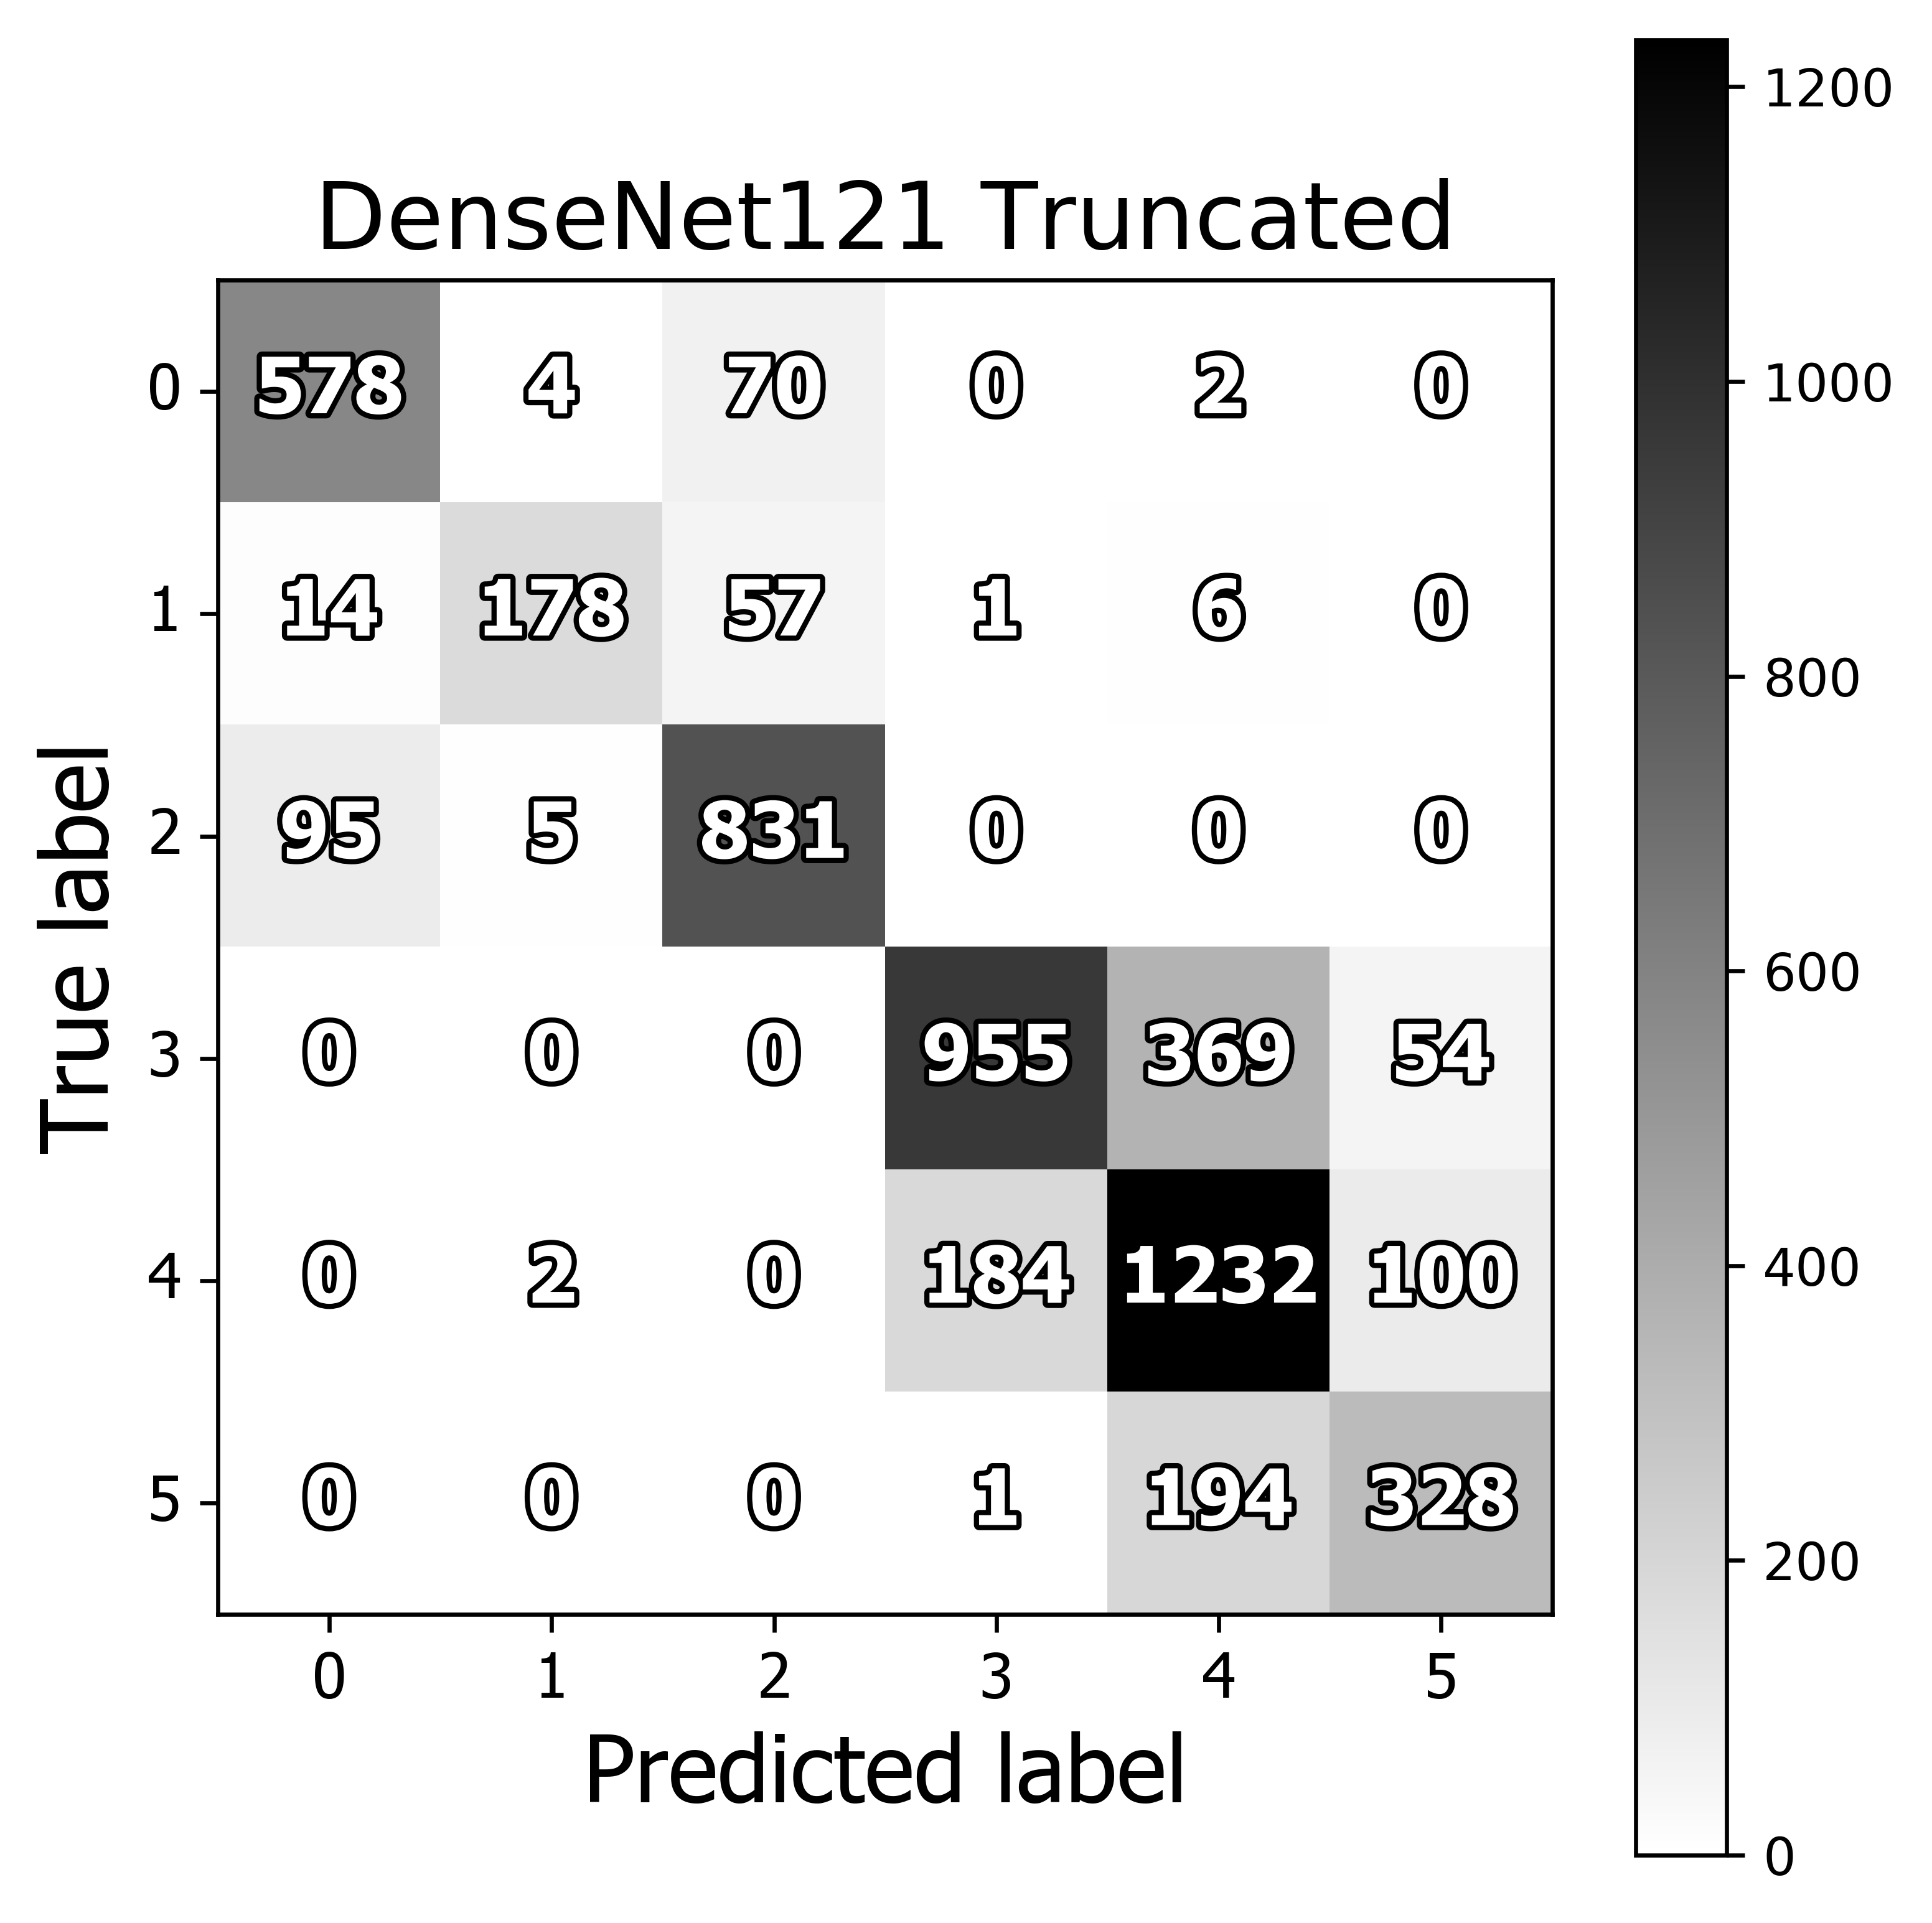

In [10]:
# DenseNet121 Confusion Matrix

fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='DenseNet121 Truncated',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")
#     plt.rcParams.update({'font.size': 70})

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, cm[i, j],
                 fontfamily = 'Tahoma', 
                 fontsize=15, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#%% print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['0', '1', '2', '3', '4', '5']
print(classification_report(Y_test,densenet121_model_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test,densenet121_model_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25, 5.25), dpi=600)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

# plt.savefig("figures/Both_truncated/DenseNet121/confusion_matrix-densenet121.jpg", bbox="tight", dpi=300)
plt.show()

In [12]:
#CURVES

import scikitplot 

plt.rcParams.update({'figure.figsize': [6,6]})
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.borderpad': 0.2})
plt.rcParams.update({'legend.fontsize': 'xx-large'})
plt.rcParams.update({'legend.frameon': True})

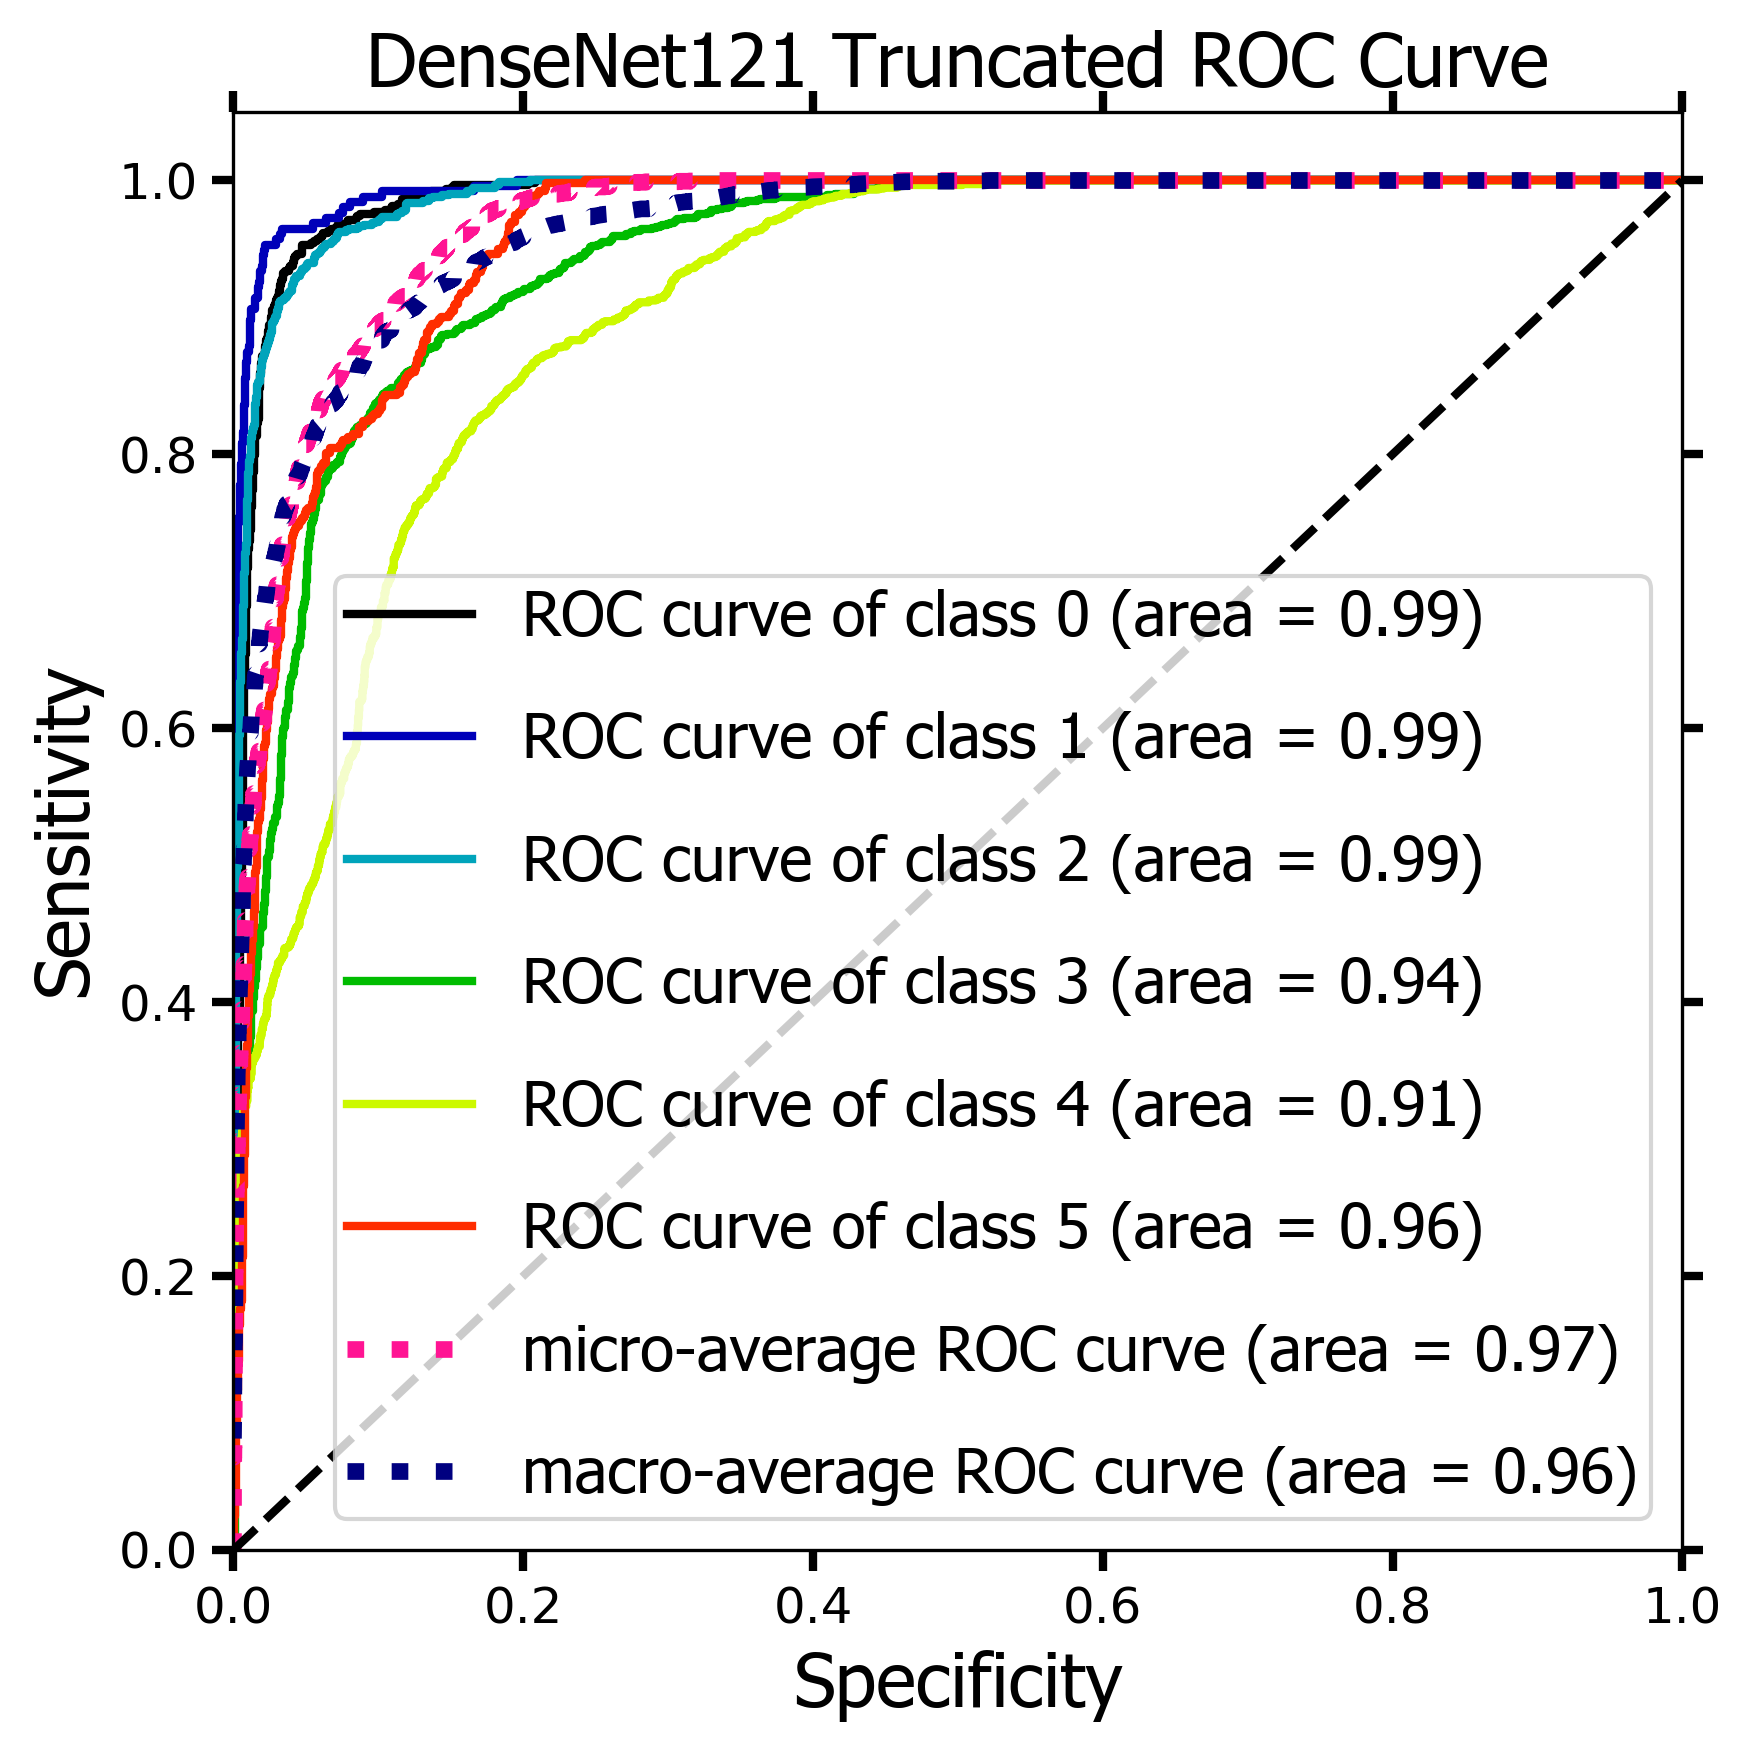

In [13]:
y_probas = densenet121_model.predict(validation_generator)
scikitplot.metrics.plot_roc(Y_test, y_probas)
plt.title('DenseNet121 Truncated ROC Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Specificity', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Sensitivity', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
legend = plt.legend(loc="lower right", fontsize=15, labelspacing=1)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.savefig("figures/Both_truncated/DenseNet121/ROC_Curve-densenet121.jpg", dpi=600)
plt.show()

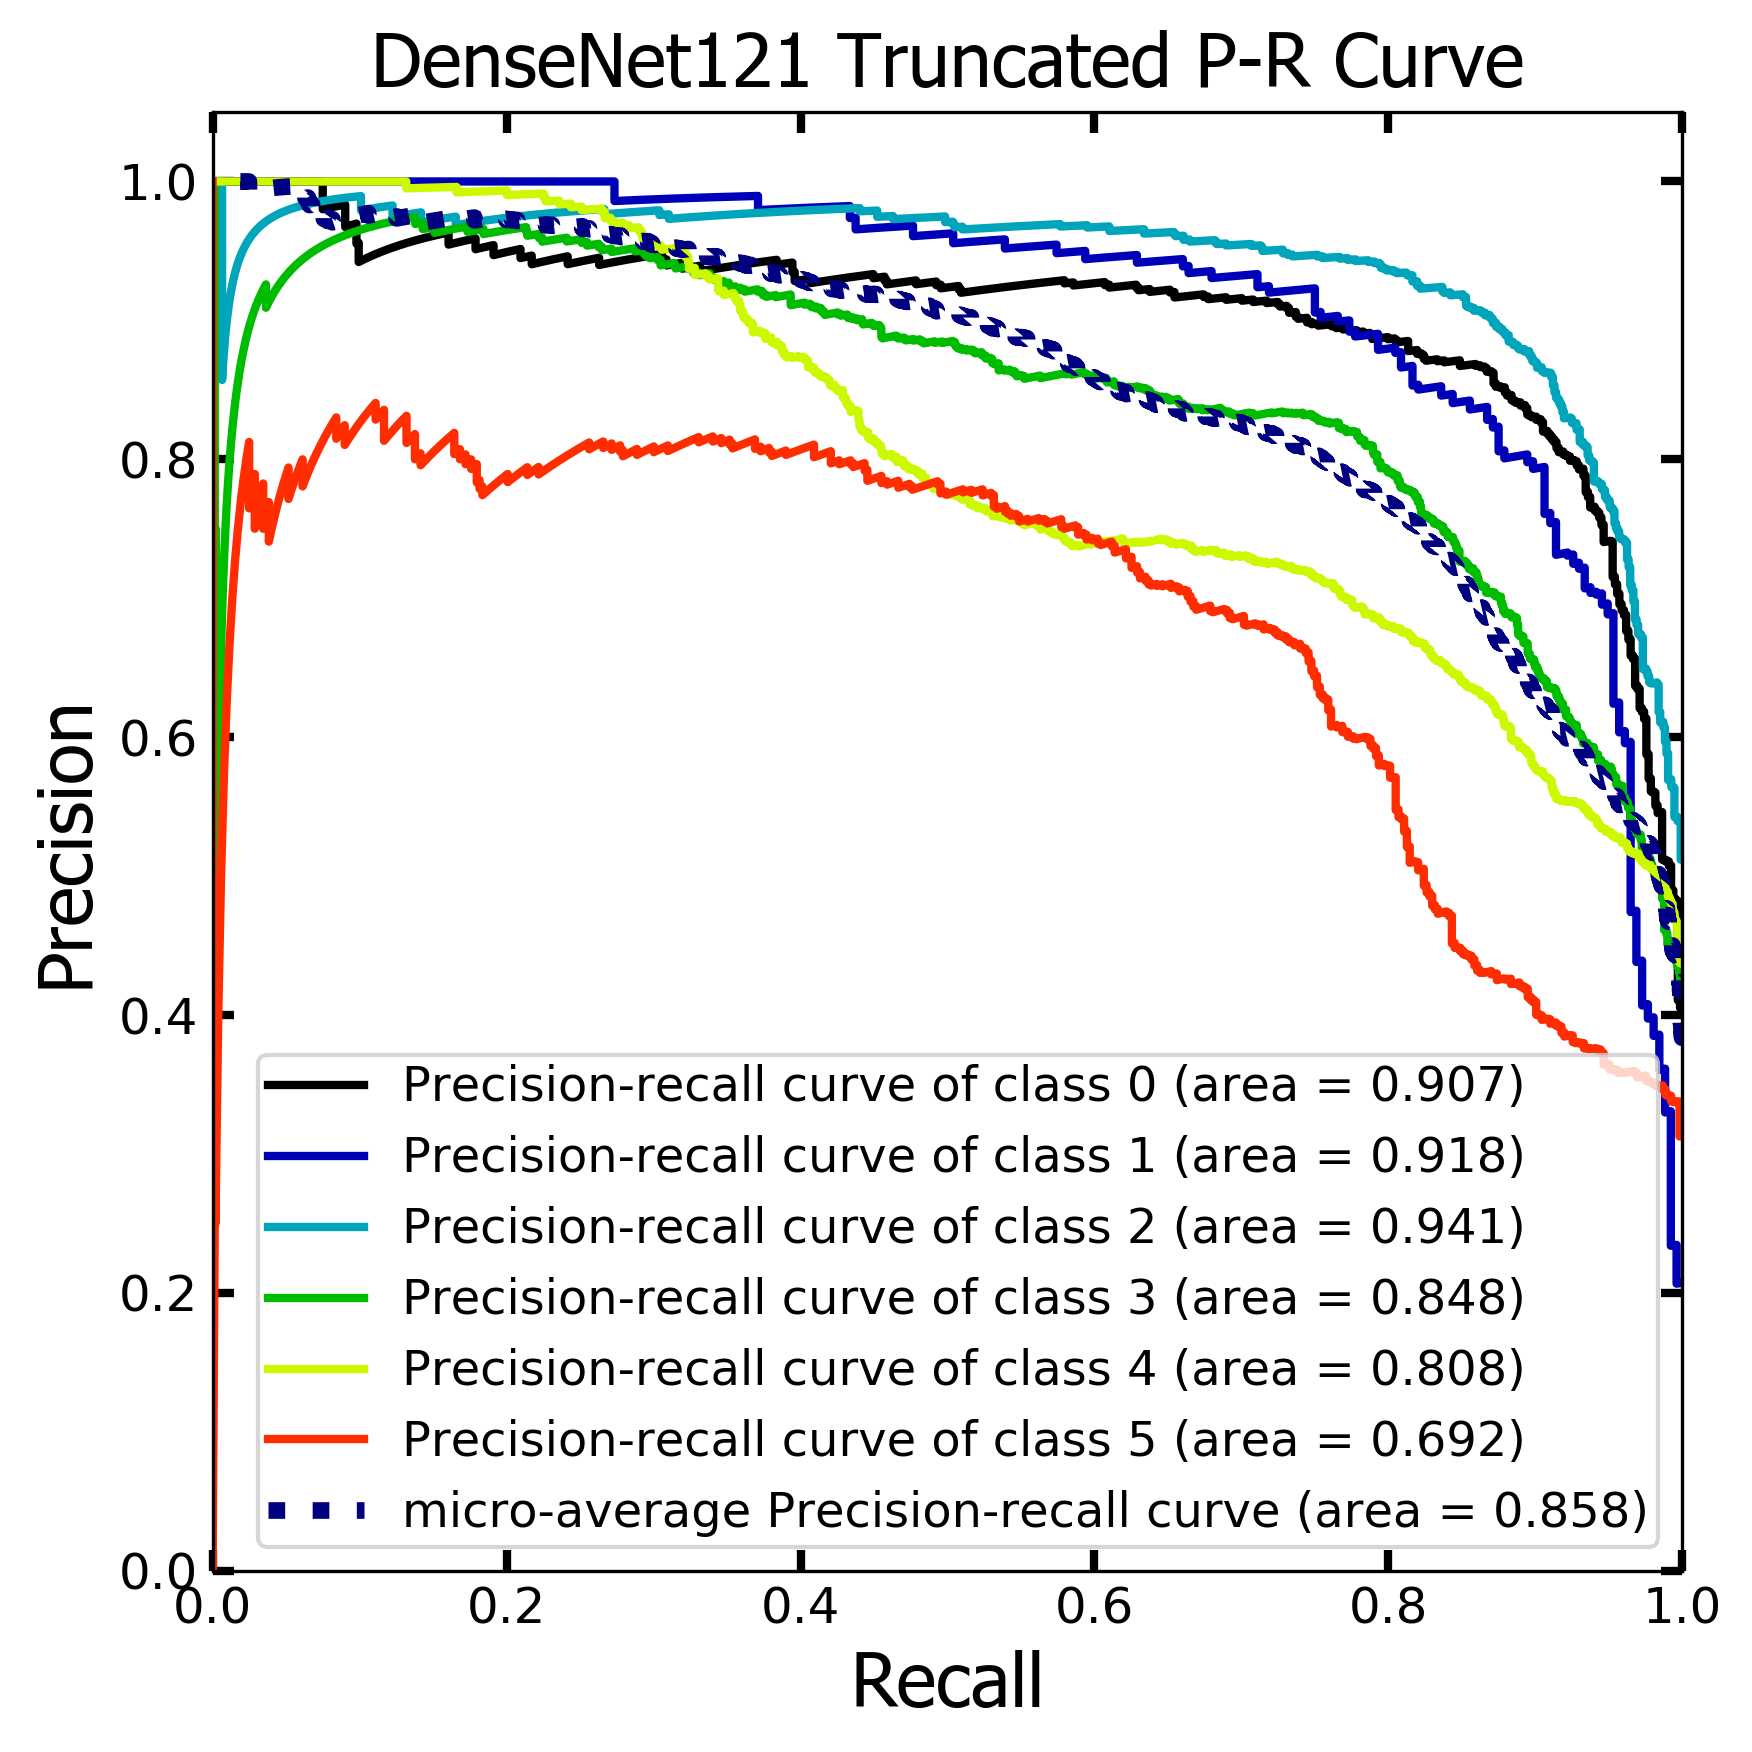

In [14]:
y_probas = densenet121_model.predict(validation_generator)
scikitplot.metrics.plot_precision_recall(Y_test, y_probas)
plt.title('DenseNet121 Truncated P-R Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Recall', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Precision', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
plt.legend(loc="lower right", fontsize=11.5, labelspacing=0.5)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.savefig("figures/Both_truncated/DenseNet121/PR_Curve-densenet121.jpg", dpi=600)
plt.show()